<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#コメント" data-toc-modified-id="コメント-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>コメント</a></span></li><li><span><a href="#import" data-toc-modified-id="import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>import</a></span></li><li><span><a href="#ゲームの位置とサイズ調整" data-toc-modified-id="ゲームの位置とサイズ調整-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ゲームの位置とサイズ調整</a></span></li><li><span><a href="#DQN" data-toc-modified-id="DQN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DQN</a></span><ul class="toc-item"><li><span><a href="#import" data-toc-modified-id="import-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>import</a></span></li><li><span><a href="#GPU判定" data-toc-modified-id="GPU判定-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>GPU判定</a></span></li><li><span><a href="#パラメータ" data-toc-modified-id="パラメータ-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>パラメータ</a></span></li><li><span><a href="#関数" data-toc-modified-id="関数-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>関数</a></span></li></ul></li><li><span><a href="#スレッド" data-toc-modified-id="スレッド-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>スレッド</a></span><ul class="toc-item"><li><span><a href="#画像取得" data-toc-modified-id="画像取得-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>画像取得</a></span></li><li><span><a href="#スコア" data-toc-modified-id="スコア-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>スコア</a></span></li><li><span><a href="#報酬" data-toc-modified-id="報酬-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>報酬</a></span></li><li><span><a href="#録画" data-toc-modified-id="録画-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>録画</a></span></li></ul></li><li><span><a href="#学習" data-toc-modified-id="学習-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>学習</a></span></li><li><span><a href="#0-0になる数(ゲーム数)" data-toc-modified-id="0-0になる数(ゲーム数)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>0-0になる数(ゲーム数)</a></span></li><li><span><a href="#モデル保存" data-toc-modified-id="モデル保存-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>モデル保存</a></span></li><li><span><a href="#中間層確認" data-toc-modified-id="中間層確認-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>中間層確認</a></span><ul class="toc-item"><li><span><a href="#Raw" data-toc-modified-id="Raw-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Raw</a></span></li><li><span><a href="#Gray-scale" data-toc-modified-id="Gray-scale-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Gray scale</a></span></li><li><span><a href="#resize" data-toc-modified-id="resize-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>resize</a></span></li><li><span><a href="#conv" data-toc-modified-id="conv-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>conv</a></span></li></ul></li></ul></div>

# コメント

- 報酬を-1, 0, 1に変更せず、やはりスコアで傾斜つけた方がいい。理由はは-1,0,1だと点数取っただけだと報酬に反映されず、学習が遅くなる

# import

In [1]:
import numpy as np
import cv2
from Tennis_observation import *
from Tennis_action import *
from window_controlle import *
import re
import sys
import copy
import os
import random
import matplotlib.pyplot as plt

In [2]:
import threading
from multiprocessing import Process
import subprocess
import time
from win32 import win32gui

# ゲームの位置とサイズ調整

In [3]:
#ゲーム画面の位置調整
#1920×1200の画面において右上四分の一に配置
win_left = 953
win_top = 0
win_width = 974
win_height = 587

In [4]:
#grab_screen
#1920×1200の画面において右上四分の一に配置した画面のゲーム部分だけを取得
left = 1087
top = 30
width = 705
height = 545

#少し大きめに画像をとってくる
size_delta = 5

In [5]:
#cnnに渡すときの画像サイズ
width_cnn = 84
height_cnn = 84

In [6]:
gray_frag = True

In [9]:
adjust_window_pos_size(win_left, win_top, win_width, win_height)

In [10]:
frame = grab_screen(left, top, width, height, False)

imshow(frame)

# DQN

## import 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

## GPU判定

In [12]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

## パラメータ

In [13]:
#学習率
learning_rate = 0.0001
#ゲーム数
num_episodes = 500
gamma = 0.99

hidden_layer = 512

replay_mem_size = 100000
batch_size = 32

update_target_frequency = 5000

double_dqn = True

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 10000

report_interval = 10
score_to_solve = 18

clip_error = True
normalize_image = True

file2save = './model/tennis_save.pth'
save_model_frequency = 10000
resume_previous_training = False

In [14]:
position = 0
capacity = 4

In [15]:
output_list = ['state', 'action', 'new_state', 'reward', 'done', 'info']

number_of_inputs = frame.shape[0]
number_of_outputs = len(keys_to_press)
number_of_skips = 10

In [16]:
# reward
init_flag = ('0.0','0.0')
score_reward_dict = {'0.0':0, '15.0':1, '30.0':2, '40.0':3, '60.0':4, '99':99, 'nan':np.nan}

## 関数

In [17]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * math.exp(-1. * steps_done / egreedy_decay)
    
    return epsilon

In [18]:
def load_model():
    return torch.load(file2save)

In [19]:
def save_model(model):
    torch.save(model.state_dict(), file2save)

In [20]:
def preprocess_frame(frame):
    frame = frame.transpose((2,0,1))
    frame = torch.from_numpy(frame)
    frame = frame.to(device, dtype=torch.float32)
    frame = frame.unsqueeze(1)
    
    return frame

In [21]:
def plot_results():
    plt.figure(figsize=(12,5))
    plt.title('Rewards')
    plt.plot(reards_total, alpha=0.6, color='red')
    plt.savefig('Tennis_result.png')
    plt.close()

In [22]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)

In [236]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        self.advantage1 = nn.Linear(7*7*64,hidden_layer)
        self.advantage2 = nn.Linear(hidden_layer, number_of_outputs)
        
        self.value1 = nn.Linear(7*7*64,hidden_layer)
        self.value2 = nn.Linear(hidden_layer,1)

        #self.activation = nn.Tanh()
        self.activation = nn.ReLU()
        
        
    def forward(self, x):
        
        if normalize_image:
            x = x / 255
        
        output_conv = self.conv1(x)
        output_conv = self.activation(output_conv)        
        
        
        
        output_conv = self.conv2(output_conv)
        output_conv = self.activation(output_conv)
        output_conv = self.conv3(output_conv)
        output_conv = self.activation(output_conv)
        
        output_conv = output_conv.view(output_conv.size(0), -1) # flatten
        
        
        
        output_advantage = self.advantage1(output_conv)
        output_advantage = self.activation(output_advantage)
        output_advantage = self.advantage2(output_advantage)
        
        output_value = self.value1(output_conv)
        output_value = self.activation(output_value)
        output_value = self.value2(output_value)
        
        output_final = output_value + output_advantage - output_advantage.mean()
        
        middle_img = copy.copy(output_conv)

        return output_final, middle_img

In [237]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.number_of_frames = 0
        
        if resume_previous_training and os.path.exists(file2save):
            print("Loading previously saved model ... ")
            self.nn.load_state_dict(load_model())
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:
            
            with torch.no_grad():
                
                state = preprocess_frame(state)
                action_from_nn = self.nn(state)
                
                action = torch.max(action_from_nn,1)[1]
                action = action.item()        
        else: # random
            action = action_random()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = [ preprocess_frame(frame) for frame in state ] 
        state = torch.cat(state)
        
        new_state = [ preprocess_frame(frame) for frame in new_state ] 
        new_state = torch.cat(new_state)

        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)


        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]  
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]
        
        
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.number_of_frames % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        if self.number_of_frames % save_model_frequency == 0:
            save_model(self.nn)
        
        self.number_of_frames += 1

# スレッド

## 画像取得

In [23]:
frame_current = {'frame':grab_screen(left, top, width, height, False)}
stop_flag = {'flag':False}

In [24]:
t1 = threading.Thread(target=observation, args=(left, top, width, height, frame_current, stop_flag))
t1.start()

imshow(frame_current['frame'])

## スコア

In [25]:
def get_score(my_score, enemy_score, stop_flag):
    while True:
        # score取得
        score = score_check(frame_current['frame'])
        my_score['my_score'] = float(score[0])
        enemy_score['enemy_score'] = float(score[1])

        if stop_flag['flag'] == True:
            print('stop getting score')
            break

In [26]:
my_score = {'my_score':0}
enemy_score = {'enemy_score':0}

t2 = threading.Thread(target=get_score, args=(my_score, enemy_score, stop_flag))
t2.start()

my_score = {'my_score':0}
enemy_score = {'enemy_score':0}

t2 = threading.Thread(target=get_score, args=(my_score, enemy_score, frame_current['frame'], stop_flag))
t2.start()

In [27]:
print(my_score['my_score'], enemy_score['enemy_score'])

0.0 40.0


In [28]:
imshow(frame_current['frame'])

In [29]:
enemy_score

{'enemy_score': 40.0}

## 報酬

In [30]:
point_fin_flag = {'point_fin_flag':False}

In [31]:
def reward_calculation(my_last_score, enemy_last_score, reward, stop_flag):
    #スコアと報酬初期化
    score = ('99', '99')
    last_score = ('99', '99')
    reward = -3
    count_game = 0
    
    while stop_flag['flag'] != True:
        #スコア取得
        score = (str(my_score['my_score']), str(enemy_score['enemy_score']))
        
        #ポイント終了
        if (score != last_score) & ('nan' not in score):
            point_fin_flag['point_fin_flag'] = True
            #print('score:', str(score))
            
            #(0,0)で報酬清算
            #1ゲーム目の0-0は報酬計算対象外
            if (score == init_flag) & (count_game == 0):
                count_game += 1
                #print('game: ', count_game)
            
            #2ゲーム目以降
            if (score == init_flag) & (count_game > 0):
                reward = score_reward_dict[last_score[0]] - score_reward_dict[last_score[1]]
                #print('reward:', str(reward))
                
                count_game += 1
                #print('game: ', count_game)
            
            #0-0の認識できなかった時の報酬計算処理
            #if
            

            last_score = copy.copy(score)
            my_last_score['my_last_score'] = last_score[0]
            enemy_last_score['enemy_last_score'] = last_score[1]
            
    
    print('fin')

reward = {'reward':-3}
my_last_score = {'my_last_score': '99'}
enemy_last_score = {'enemy_last_score': '99'}


t3 = threading.Thread(target=reward_calculation, args=(my_last_score, enemy_last_score, reward, stop_flag))
t3.start()

print(my_last_score['my_last_score'], enemy_last_score['enemy_last_score'])

## 録画

In [32]:
video_stop_flag = {'flag':False}
t4 = Process(target=video_record, args=(stop_flag, True)) # argsで引数二つ以上じゃないとエラー出る
t4.start()

In [34]:
stop_flag['frag'] = True

In [63]:
score_check(frame_current['frame'])

('0', '15')

imshow(frame_current['frame'])

# 学習

In [64]:
resume_previous_training = True

In [65]:
memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()


reward_list = []
score_list = []

#frames_total = 10000694a4a
count_game = 0

active_window()
reward = 0.0

done = False

score = ('99', '99')
last_score = ('99', '99')

# 0-0になる数(ゲーム数)
for i_episode in range(num_episodes):
    

    score_list_buf = []
    reward_list_buf = []
    
    new_state = image_gray_resize(frame_current['frame'], width_cnn, height_cnn)
    state = new_state
    
    # 1ゲーム終わるまで継続
    while True:
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #行動決定
        action = qnet_agent.select_action(state, epsilon)
        
        #行動
        take_action(action)
        
        #新しい環境
        state = new_state
        
        new_state = image_gray_resize(frame_current['frame'], width_cnn, height_cnn)
        
        score = (str(my_score['my_score']), str(enemy_score['enemy_score']))
        
        #ゲームが終わったかの確認               
        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        #ポイント終了
        if (score != last_score) & ('nan' not in score):
            print('score:', str(score))
            
            score_list_buf.append(score)
            
            #(0,0)で報酬清算
            #1ゲーム目の0-0は報酬計算対象外
            if (score == init_flag) & (count_game == 0):
                count_game += 1
                print('game: ', count_game)
            
            #2ゲーム目以降
            if (score == init_flag) & (count_game > 0):
                reward = score_reward_dict[last_score[0]] - score_reward_dict[last_score[1]]
                reward_list.append(reward)
                print('reward:', str(reward))
                
                count_game += 1
                print('game: ', count_game)
            
            #0-0の認識できなかった時の報酬計算処理
            #if

            last_score = copy.copy(score)
            break
        
        score_list.append(score_list_buf)
        

Loading previously saved model ... 
score: ('0.0', '15.0')
score: ('0.0', '30.0')
score: ('0.0', '40.0')
score: ('0.0', '30.0')
score: ('0.0', '40.0')
score: ('0.0', '15.0')
score: ('0.0', '40.0')
score: ('0.0', '0.0')
game:  1
reward: -3
game:  2
score: ('15.0', '40.0')
score: ('0.0', '15.0')
score: ('0.0', '40.0')
score: ('0.0', '0.0')
reward: -3
game:  3
score: ('0.0', '15.0')
score: ('0.0', '0.0')
reward: -1
game:  4
score: ('0.0', '15.0')
score: ('0.0', '30.0')
score: ('0.0', '40.0')
score: ('0.0', '0.0')
reward: -3
game:  5
score: ('0.0', '15.0')
score: ('0.0', '40.0')
score: ('0.0', '0.0')
reward: -3
game:  6
score: ('0.0', '30.0')
score: ('0.0', '40.0')
score: ('15.0', '30.0')
score: ('0.0', '0.0')
reward: -1
game:  7
score: ('15.0', '0.0')
score: ('30.0', '0.0')
score: ('40.0', '0.0')
score: ('40.0', '15.0')
score: ('40.0', '30.0')
score: ('0.0', '0.0')
reward: 1
game:  8
score: ('0.0', '15.0')
score: ('0.0', '0.0')
reward: -1
game:  9
score: ('0.0', '15.0')


KeyboardInterrupt: 

In [51]:
my_score

{'my_score': 0.0}

In [53]:
enemy_score

{'enemy_score': 0.0}

In [52]:
score

('0.0', '0.0')

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()


reward_list = []
frames_total = 10000
score_list = []

count_game = 0

active_window()
reward = -3

done = False

score = ('99', '99')
last_score = ('99', '99')

# 0-0になる数(ゲーム数)
for i_episode in range(num_episodes):
    done = False

    score_list_buf = []
    reward_list_buf = []
    
    new_state = image_gray_resize(frame_current['frame'], width_cnn, height_cnn)
    state = new_state
    
    # 1ゲーム終わるまで継続
    while True:
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #行動決定
        action = qnet_agent.select_action(state, epsilon)
        
        #行動
        take_action(action)
        
        #新しい環境
        state = new_state
        
        new_state = image_gray_resize(frame_current['frame'], width_cnn, height_cnn)
        
        score = (str(my_score['my_score']), str(enemy_score['enemy_score']))
        
        #ゲームが終わったかの確認               
        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        #ポイント終了
        #done
        if (point_fin_flag['point_fin_flag'] == True) & ('nan' not in score):
            point_fin_flag['point_fin_flag'] = False
            
            score_list_buf.append(score)
            print('score:', str(score))
            
            #(0,0)で報酬計算
            if (score == init_flag) & (count_game > 0):
                reward = score_reward_dict[last_score[0]] - score_reward_dict[last_score[1]]
                print('reward:', str(reward))
                
                count_game += 1
                print('game: ', count_game)
                
                done = True
            
            if (score == init_flag) & (count_game == 0):
                count_game += 1
                print('game: ', count_game)
            
            last_score = copy.copy(score)
        
    score_list.append(score_list_buf)

In [39]:
my_score

{'my_score': nan}

In [37]:
last_score

('40.0', '40.0')

In [40]:
score

('40.0', '40.0')

In [39]:
score_check(frame_current['frame'])

('15', '15')

In [ ]:
('0.0', '15.0')
('30.0', '30.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('15.0', '15.0')
('30.0', '15.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '0.0')
('15.0', '15.0')
('40.0', '15.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('30.0', '0.0')
('40.0', '0.0')
('40.0', '15.0')
('40.0', '30.0')
('40.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('15.0', '15.0')
('30.0', '15.0')
('40.0', '30.0')
('60.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '0.0')
reward: -3
('0.0', '0.0')
reward: -3
('15.0', '0.0')
('30.0', '15.0')
('40.0', '15.0')
('0.0', '0.0')
reward: 2
wining after 29 games
('0.0', '0.0')
reward: 2
wining after 30 games
('0.0', '0.0')
reward: 2
wining after 31 games
('0.0', '0.0')
reward: 2
wining after 32 games
('0.0', '0.0')
reward: 2
wining after 33 games
('0.0', '15.0')
('0.0', '40.0')
('30.0', '0.0')
('30.0', '15.0')
('0.0', '15.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '0.0')
reward: -2
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('30.0', '15.0')
('40.0', '40.0')
('0.0', '0.0')
reward: 0
('0.0', '15.0')
('0.0', '30.0')
('15.0', '30.0')
('15.0', '40.0')
('30.0', '40.0')
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '0.0')
reward: -1
('0.0', '15.0')
('15.0', '15.0')
('30.0', '15.0')
('40.0', '30.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('30.0', '15.0')
('30.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('0.0', '40.0')
('0.0', '30.0')
('15.0', '30.0')
('30.0', '40.0')
('60.0', '40.0')
('0.0', '15.0')
('0.0', '30.0')
('15.0', '30.0')
('15.0', '40.0')
('0.0', '0.0')
reward: -2
('0.0', '15.0')
('15.0', '15.0')
('15.0', '30.0')
('15.0', '40.0')
('0.0', '15.0')
('15.0', '15.0')
('15.0', '30.0')

In [52]:
score_list_buf

[]

# モデル保存

In [ ]:
save_model(qnet_agent.nn)

In [516]:
frame = grab_screen(left, top, width, height, False)

In [517]:
cv2.imwrite('a.png',frame)

True

# 中間層確認

In [135]:
cnn = NeuralNetwork().to(device)

## Raw

In [136]:
frame_1 = grab_screen(left, top, width, height, False)

In [137]:
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_RGB2BGR)

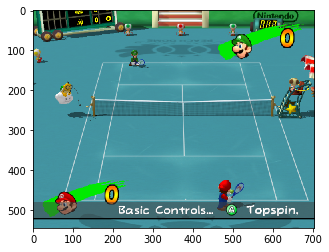

In [138]:
plt.imshow(frame_1)

In [139]:
frame_1.shape

(545, 705, 3)

In [140]:
plt.savefig('frame_1.png')

<Figure size 432x288 with 0 Axes>

## Gray scale

In [141]:
frame_2 = grab_screen(left, top, width, height, True)

In [142]:
frame_2.shape

(545, 705)

In [143]:
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BAYER_RG2BGR)

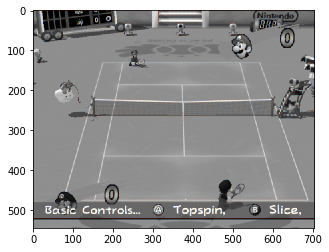

In [144]:
plt.imshow(frame_2)

## resize

In [193]:
frame_3 = grab_screen(left, top, width, height, True)

frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BAYER_RG2BGR)

In [194]:
frame_3 = image_resize(frame_3, width_cnn, height_cnn)

In [195]:
frame_3.shape[0]

84

In [196]:
frame_3 = frame_3.reshape(frame_3.shape[0], frame_3.shape[1])

In [197]:
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_GRAY2BGR)

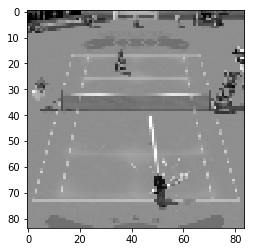

In [198]:
plt.imshow(frame_3)

## conv

In [273]:
frame_4 = grab_screen(left, top, width, height, True)

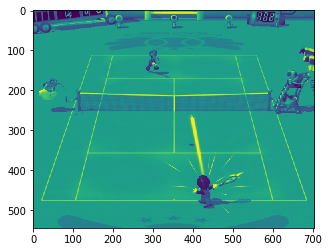

In [274]:
plt.imshow(frame_4)

In [275]:
frame_4 = image_resize(frame_4, width_cnn, height_cnn)

In [276]:
frame_4 = preprocess_frame(frame_4)

In [277]:
frame_4 = cnn(frame_4)

In [278]:
frame_4 = frame_4[1]

In [279]:
frame_4 = frame_4[0][0]

In [280]:
frame_4 = (Tensor.cpu(frame_4.detach())).numpy()

In [281]:
frame_4 = cv2.cvtColor(frame_4, cv2.COLOR_GRAY2BGR)

In [282]:
frame_4

array([[[0.        , 0.        , 0.        ],
        [0.02720962, 0.02720962, 0.02720962],
        [0.05208956, 0.05208956, 0.05208956],
        ...,
        [0.18662488, 0.18662488, 0.18662488],
        [0.13669752, 0.13669752, 0.13669752],
        [0.12384902, 0.12384902, 0.12384902]],

       [[0.14520083, 0.14520083, 0.14520083],
        [0.        , 0.        , 0.        ],
        [0.10651497, 0.10651497, 0.10651497],
        ...,
        [0.09093621, 0.09093621, 0.09093621],
        [0.11735632, 0.11735632, 0.11735632],
        [0.14251496, 0.14251496, 0.14251496]],

       [[0.14224681, 0.14224681, 0.14224681],
        [0.15703642, 0.15703642, 0.15703642],
        [0.14449795, 0.14449795, 0.14449795],
        ...,
        [0.14308292, 0.14308292, 0.14308292],
        [0.14187375, 0.14187375, 0.14187375],
        [0.0861399 , 0.0861399 , 0.0861399 ]],

       ...,

       [[0.17905104, 0.17905104, 0.17905104],
        [0.12249993, 0.12249993, 0.12249993],
        [0.12148234, 0

In [283]:
frame_5 = frame_4 / frame_4.max()

In [284]:
frame_5.shape

(20, 20, 3)

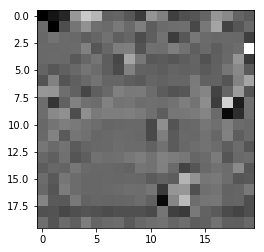

In [285]:
plt.imshow(frame_5)